In [11]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.1 MB 9.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler


import warnings

warnings.filterwarnings('ignore')

In [ ]:
! apt-get update
! apt-get install -y fonts-nanum
! fc-cache -fv
! rm -rf ~/.cache/matplotlib/*

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
%cd /workspace/

/workspace


## 양극 인장강도 Regression

In [5]:
# import excel file sheet

df = pd.read_excel('./data/230901/양극 인장강도 매칭.xlsx', sheet_name='data').loc[:38] # 원본 그대로 읽으면 불필요한 아래 시각화 정보까지 읽게 됨

# Data Pre-processing: Use data up to row 38
data_selected = df.copy()

# Define features and target 
#features = data_selected.drop(columns=["File Name", "실인장"])
features = data_selected.drop(columns=["File Name", "실인장", "출력"])

target = data_selected["실인장"]

In [6]:
features.columns

Index(['f. NIR Time_MEAN', 'a_1. LO height MEAN_MEAN',
       'a_1. LO height MEAN_STD', 'a_2. LO height MIN_MEAN',
       'a_2. LO height MIN_STD', 'a_3. LO height Peak_MEAN',
       'a_3. LO height Peak_STD', 'a_4. LO height STD_MEAN',
       'a_4. LO height STD_STD', 'b. LO FWHM_MEAN', 'b. LO FWHM_STD',
       'c. LO 면적_MEAN', 'c. LO 면적_STD', 'd. BR Peak_MEAN', 'd. BR Peak_STD',
       'e. BR Peak 시간_MEAN', 'e. BR Peak 시간_STD', 'f. NIR Time_MEAN.1',
       'f. NIR Time_STD', 'g. NIR Peak_MEAN', 'g. NIR Peak_STD',
       'h. 기준선 이상 NIR 신호 면적_MEAN', 'h. 기준선 이상 NIR 신호 면적_STD',
       'i_1. NIR 남은 신호 길이_MEAN', 'i_1. NIR 남은 신호 길이_STD',
       'i_2. NIR 남은 신호 면적_MEAN', 'i_2. NIR 남은 신호 면적_STD', 'j. 구간 면적_MEAN',
       'j. 구간 면적_STD', 'k. VIS Time_MEAN', 'k. VIS Time_STD',
       'm. VIS Peak_MEAN', 'm. VIS Peak_STD', 'n. 기준선 이상 VIS 신호 면적_MEAN',
       'n. 기준선 이상 VIS 신호 면적_STD', 'o_1. VIS 남은 신호 길이_MEAN',
       'o_1. VIS 남은 신호 길이_STD', 'o_2. VIS 남은 신호 면적_MEAN',
       'o_2. VIS 남은 신호 면적_STD

In [7]:
features.tail(5) #  마지막 시편 기록에서 s.BR9.5over_길이_MEAN의 값이 0을 기록하고 있는데, 결측치를 일괄 처리한 것인지 아니면 실제 feature가 0인지 확인 필요

,f. NIR Time_MEAN,a_1. LO height MEAN_MEAN,a_1. LO height MEAN_STD,a_2. LO height MIN_MEAN,a_2. LO height MIN_STD,a_3. LO height Peak_MEAN,a_3. LO height Peak_STD,a_4. LO height STD_MEAN,a_4. LO height STD_STD,b. LO FWHM_MEAN,...,n. 기준선 이상 VIS 신호 면적_MEAN,n. 기준선 이상 VIS 신호 면적_STD,o_1. VIS 남은 신호 길이_MEAN,o_1. VIS 남은 신호 길이_STD,o_2. VIS 남은 신호 면적_MEAN,o_2. VIS 남은 신호 면적_STD,p. BR GAP (peak LO off)_MEAN,p. BR GAP (peak LO off)_STD,s.BR 9.5over_길이_MEAN,s.BR 9.5over_길이_STD
34,14.59259,56.15911,0.04638,51.94191,1.47767,56.90352,0.22337,0.57500,0.22932,1.95630,...,11.88508,1.87205,0.10074,0.15531,0.06093,0.15095,6.74609,0.86298,0.0,0.0
35,13.75926,56.13890,0.03805,50.74992,1.53898,56.89373,0.25698,0.66952,0.18177,1.94852,...,11.55573,2.02846,0.07074,0.11352,0.03683,0.02246,6.84918,0.78282,0.0,0.0
36,12.72222,58.15111,0.04583,53.11702,1.55204,58.89609,0.22480,0.71634,0.15717,1.96889,...,11.58941,1.99180,0.08852,0.15713,0.02846,0.03673,6.62168,0.75875,0.0,0.0
37,13.44444,58.15751,0.04730,53.52529,0.94851,58.93229,0.21844,0.66902,0.12287,1.96963,...,12.21812,1.80279,0.05778,0.12430,0.02309,0.01470,6.56584,0.78887,0.0,0.0
38,12.68519,58.13589,0.03449,51.62719,0.72883,58.88037,0.22872,0.78270,0.07634,1.96000,...,12.11597,1.80205,0.04370,0.05155,0.03007,0.01656,6.71552,0.65904,0.0,0.0


In [8]:
sum(features.isna().sum()>0) # 결측치 확인 -> 결측치 없음.

0

In [9]:
target.isna().sum() # 결측치 확인 -> 결측치 없음.

0

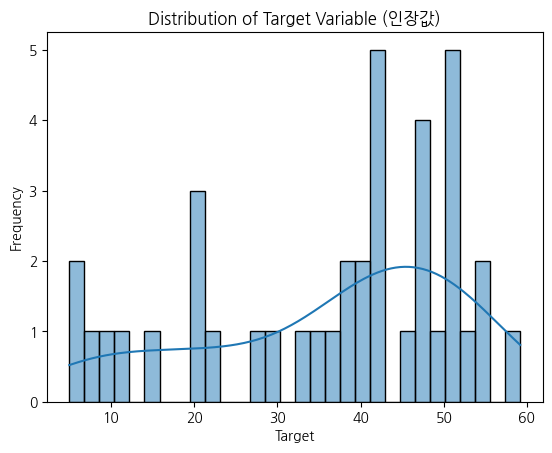

In [10]:
# EDA: Visualizations
# Histogram of the target variable
sns.histplot(target, bins=30, kde=True)
plt.title('Distribution of Target Variable (인장값)')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

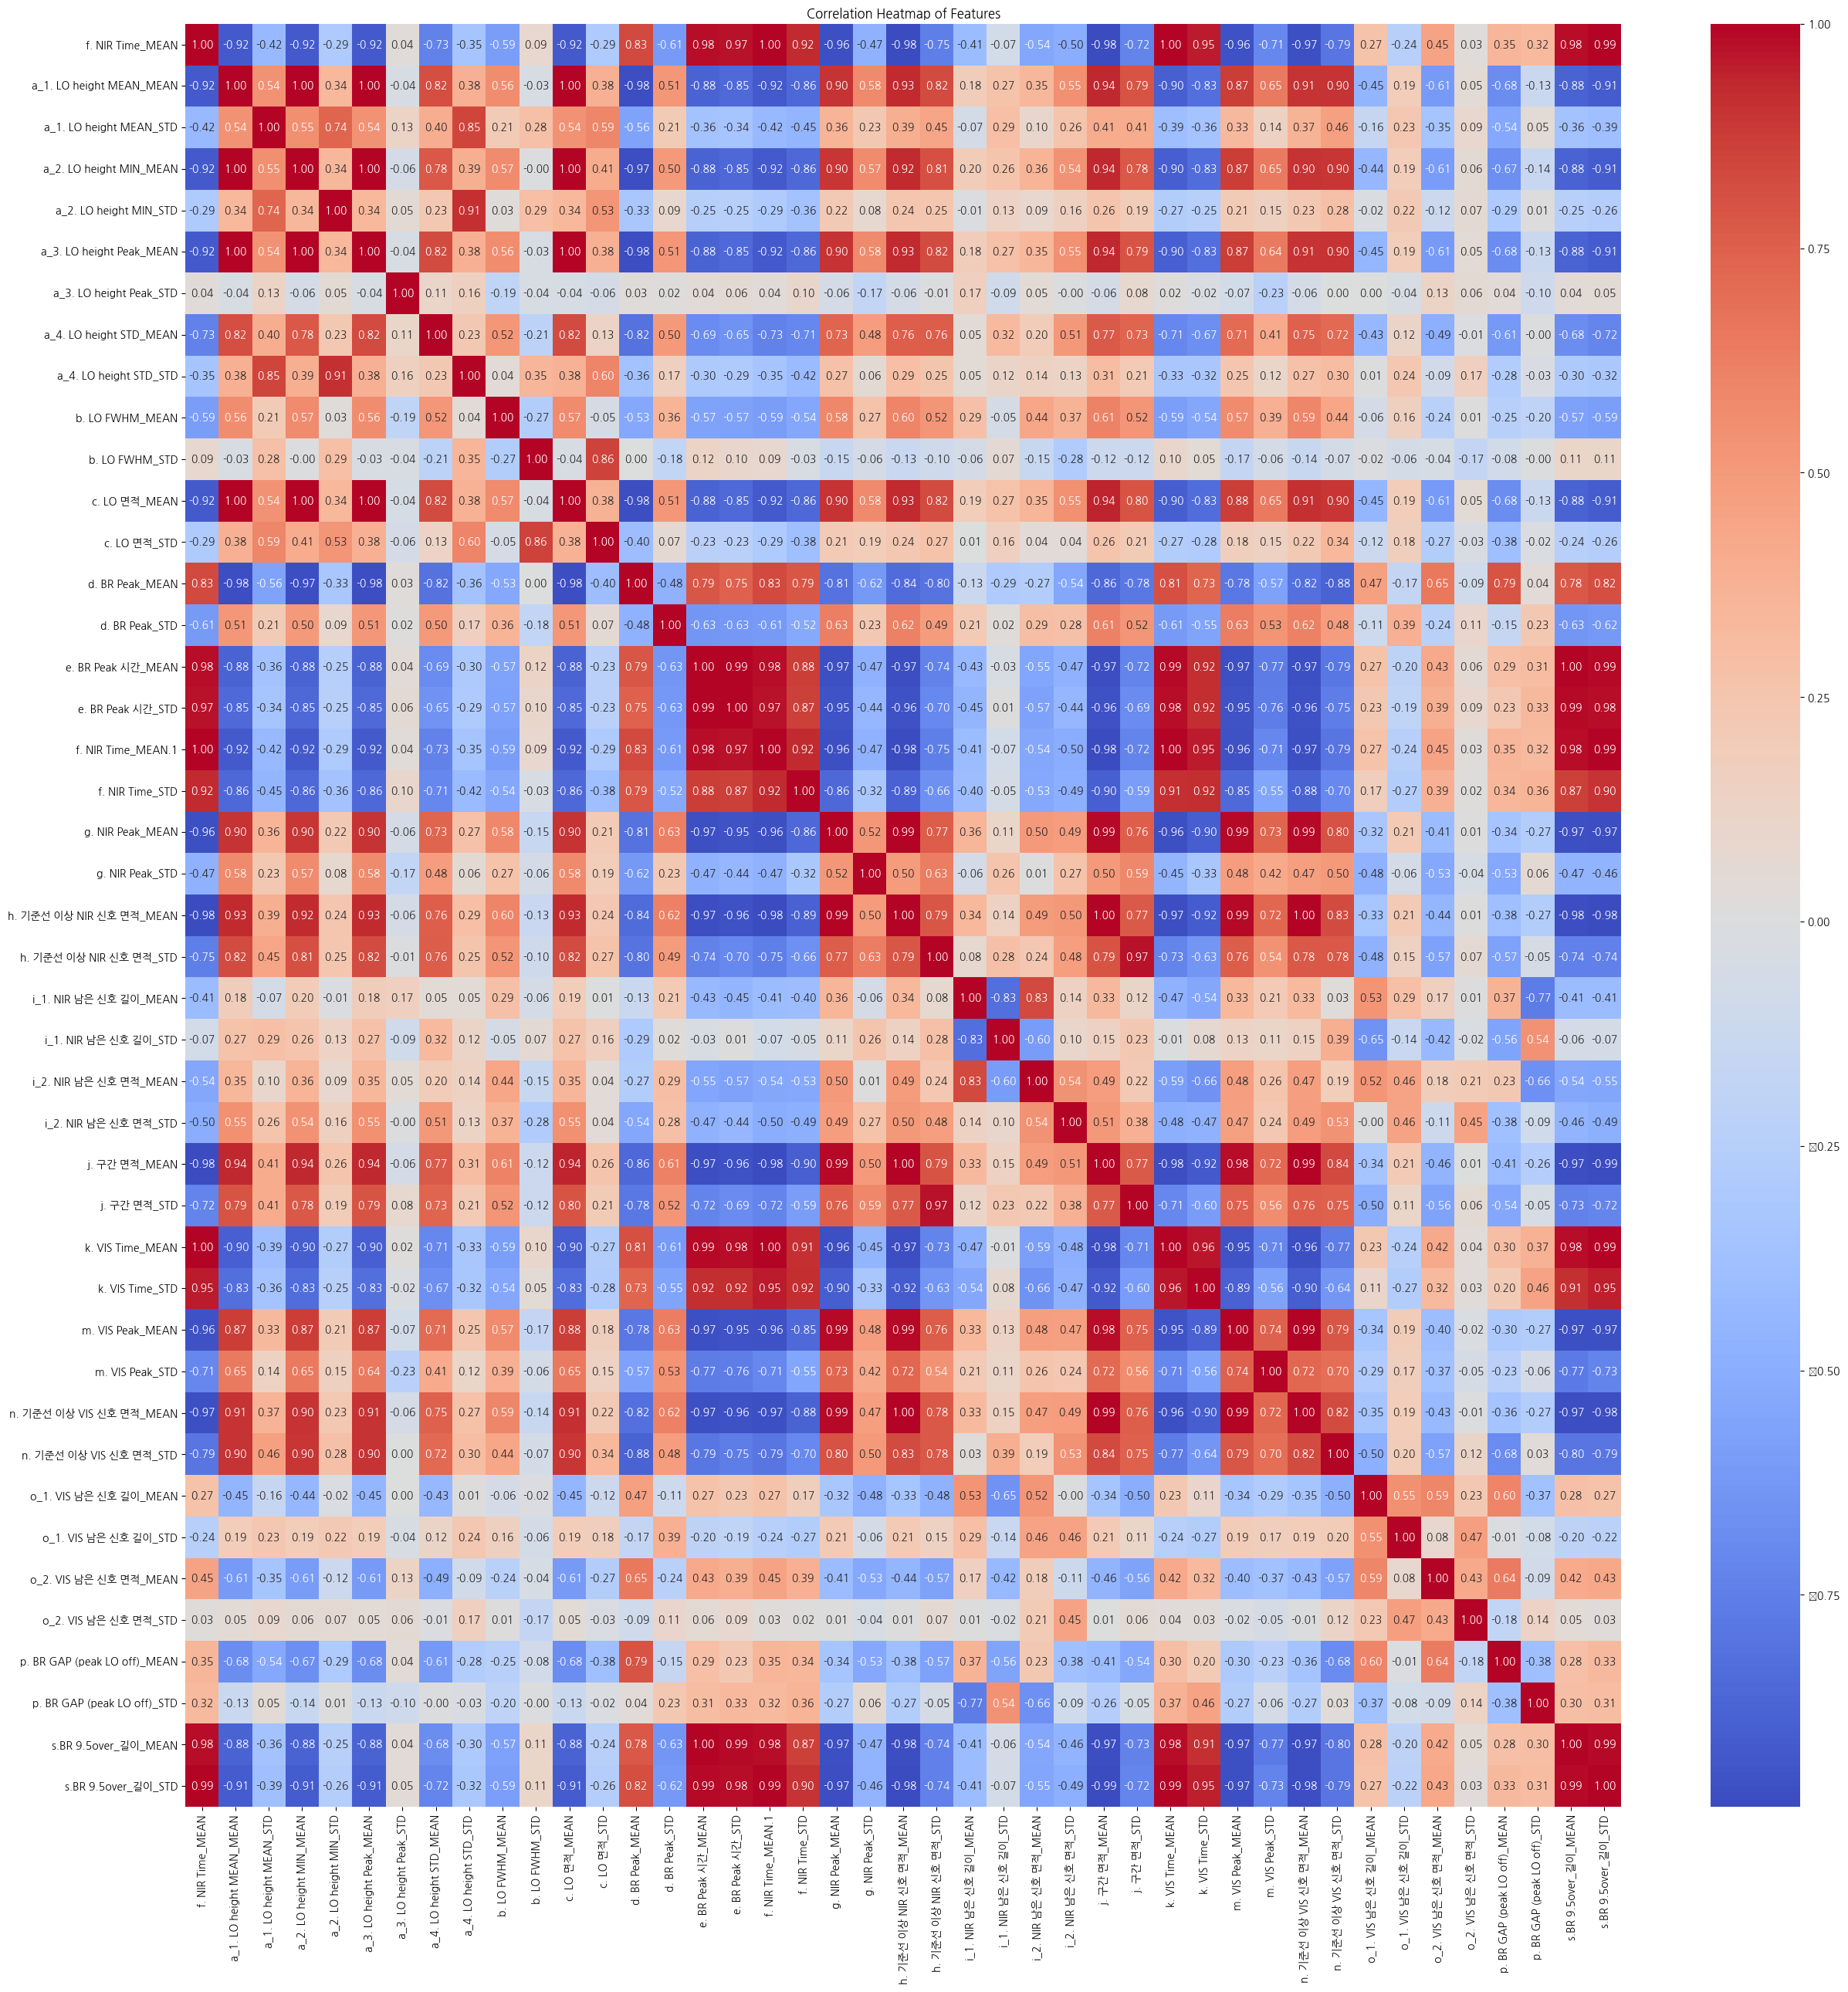

In [69]:
# Correlation heatmap of features 

plt.figure(figsize=(30, 30))
sns.heatmap(features.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [46]:
np.random.seed(42)

# Modeling with LOOCV
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective ='reg:squarederror', random_state=42,
                            tree_method='gpu_hist', 
                            gpu_id=0,
                            ),
    'LightGBM': LGBMRegressor(
                        min_data_in_leaf=1, 
                        min_split_gain=0.0, 
                        num_leaves=31, 
                        max_depth=-1,
                        lambda_l1=0.0,
                        lambda_l2=0.0,
                        learning_rate=0.05,
                        n_estimators=500,
                        random_state=42,
                        device='cpu',
                        verbose=-1
                        )
}

loocv = LeaveOneOut()

results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE'])

In [47]:
from collections import defaultdict
from tqdm import tqdm
feat_import = defaultdict(list)
 
for model_name, model in models.items():
    mse_values = []
    rmse_values = []
    predictions = []
    actuals = []
    
    for train_index, test_index in tqdm(loocv.split(features)):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Normalize data
        scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
        X_train_scaled = scaler.transform(X_train)  # Scale training data
        X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
        
        # Train model
        model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        prediction = model.predict(X_test_scaled.reshape(1,-1))
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)

        mse_values.append(mse)
        rmse_values.append(rmse)

    try:
        # Extract feature importances
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importances = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importances
        })
        
        # Sort features according to importance
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        feat_import[model_name] = feature_importances

    except AttributeError:
        print(f"{model_name} does not support feature_importances_")

    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)

    results = results.append({
        'Model': model_name,
        'MSE': agg_mse,
        'RMSE': agg_rmse
    }, ignore_index=True)

    print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}")

0it [00:00, ?it/s]

39it [00:00, 207.81it/s]


Linear Regression does not support feature_importances_
Linear Regression - MSE: 293.33, RMSE: 14.83


39it [00:00, 128.47it/s]


Ridge Regression does not support feature_importances_
Ridge Regression - MSE: 93.64, RMSE: 7.47


39it [00:00, 166.03it/s]


Lasso Regression does not support feature_importances_
Lasso Regression - MSE: 61.79, RMSE: 6.61


39it [00:01, 22.91it/s]


Gradient Boosting - MSE: 57.50, RMSE: 5.83


39it [00:03, 12.48it/s]


XGBoost - MSE: 64.63, RMSE: 5.83


39it [00:08,  4.48it/s]

LightGBM - MSE: 66.23, RMSE: 6.53


In [48]:
results # 변수간 상관관계가 태생적으로 높기 때문에 다중공산성으로 인해 Linear Regression의 성능이 좋지 않음. 규제화를 적용했을때 성능이 향상함. PCA를 통해 상관관계를 제거한 뒤에 PC를 사용하여 모델링을 하는 것도 고려할 수 있음

,Model,MSE,RMSE
0,Linear Regression,293.326194,14.833143
1,Ridge Regression,93.638738,7.465741
2,Lasso Regression,61.794610,6.613022
3,Gradient Boosting,57.502771,5.826632
4,XGBoost,64.628131,5.829688
5,LightGBM,66.225683,6.527743


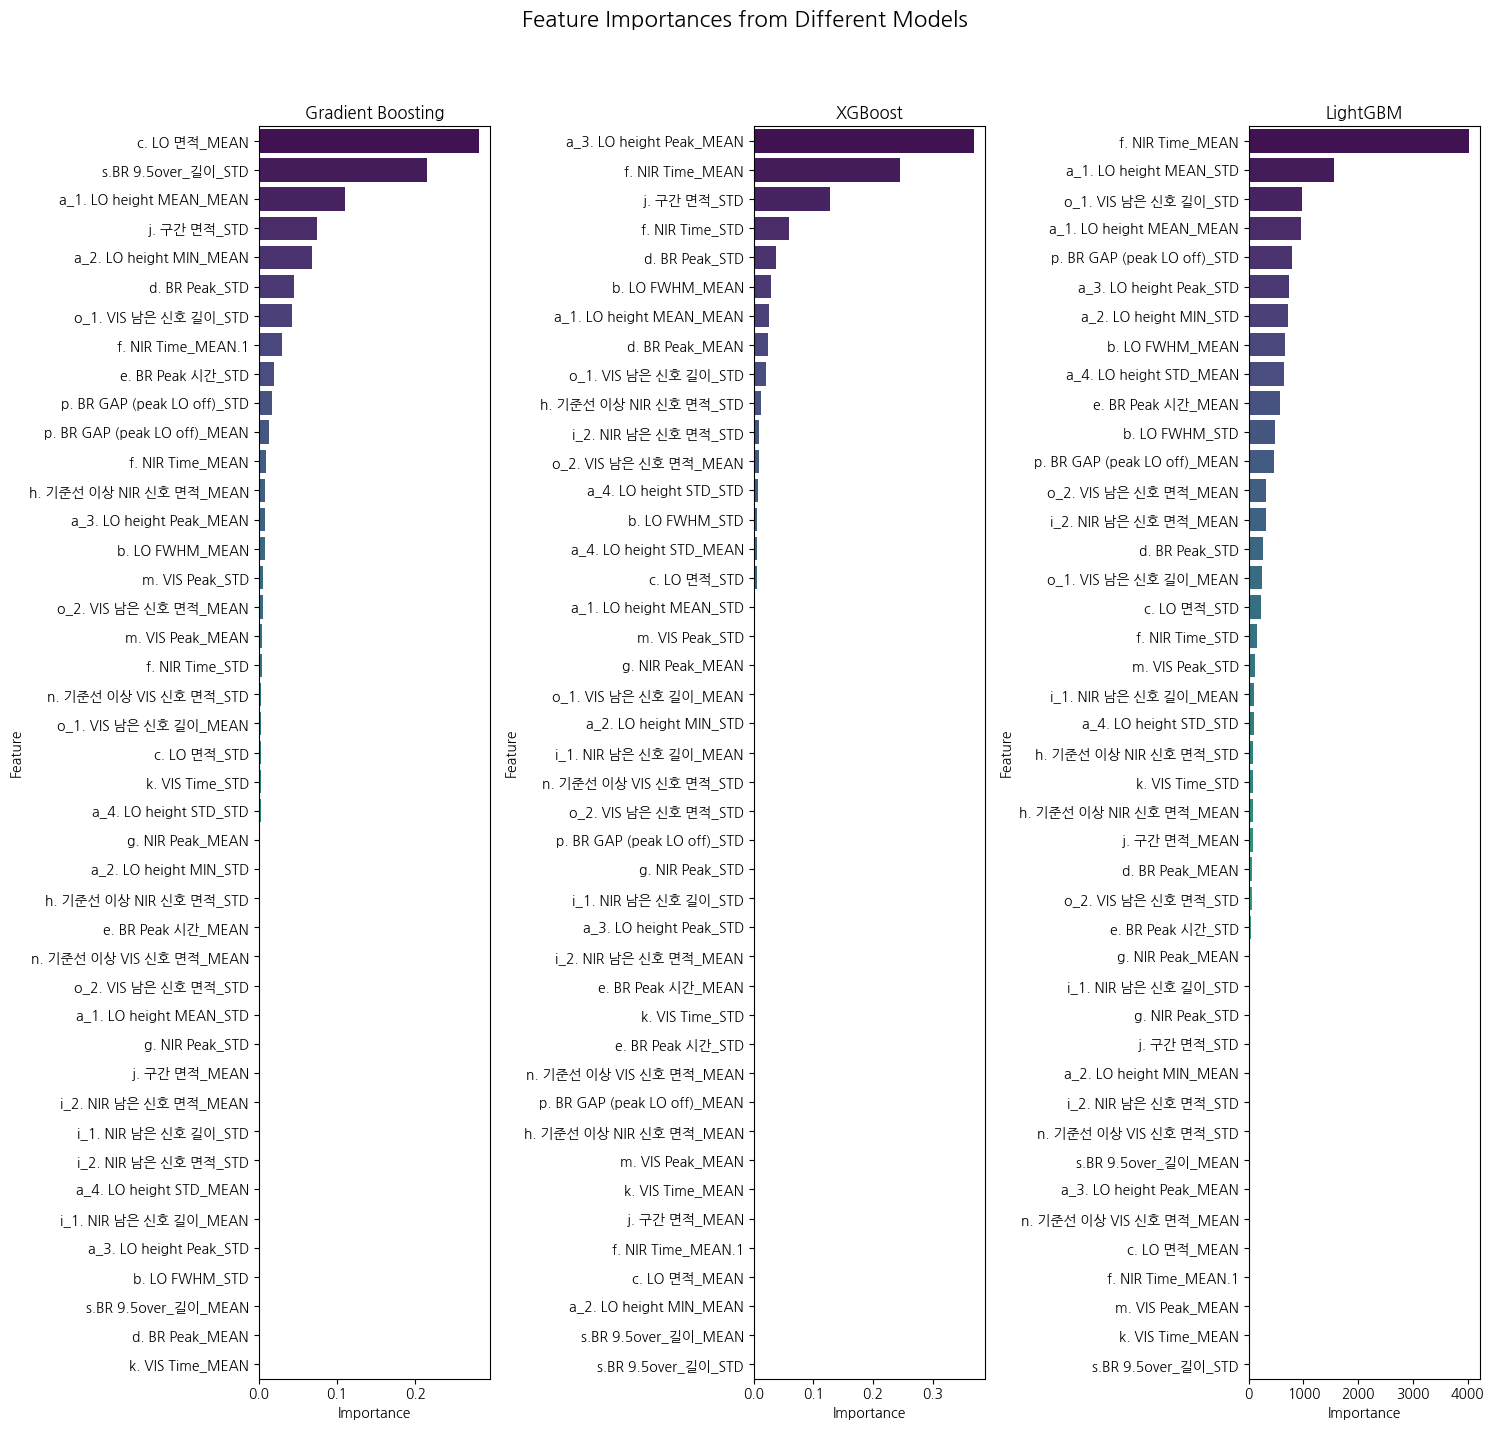

In [49]:
model_import = ['Gradient Boosting', 'XGBoost', 'LightGBM']

# Set up the matplotlib figure
num_models = len(model_import)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 15))
fig.suptitle('Feature Importances from Different Models', fontsize=16)

# Plotting
for ax, model_name in zip(axes, model_import):

    feature_importances = feat_import[model_name]
    
    # Plot
    sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax, palette='viridis')
    ax.set_title(model_name)
    ax.set_xlabel('Importance')
    
axes[0].set_ylabel('Feature')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()

In [50]:
features_best = data_selected[feat_import['Gradient Boosting']['Feature'][:5]]
feat_import_best = defaultdict(list)


mse_values = []
rmse_values = []
predictions = []
actuals = []

model_name = 'Gradient Boosting'
model = models[model_name]

for train_index, test_index in loocv.split(features_best):
    X_train, X_test = features_best.iloc[train_index], features_best.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Normalize data
    scaler = StandardScaler().fit(X_train)  # Compute mean and std on training data
    X_train_scaled = scaler.transform(X_train)  # Scale training data
    X_test_scaled = scaler.transform(X_test)  # Scale test data using training parameters
    
    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict and evaluate
    prediction = model.predict(X_test_scaled.reshape(1,-1))
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)

    mse_values.append(mse)
    rmse_values.append(rmse)
    
    agg_mse = np.mean(mse_values)
    agg_rmse = np.mean(rmse_values)

print(f"{model_name} - MSE: {agg_mse:.2f}, RMSE: {agg_rmse:.2f}")


Gradient Boosting - MSE: 54.69, RMSE: 5.37
